In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMClassifier

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/hamoye/data/"

In [ ]:
data = pd.read_csv(path + "final_data.csv")
data = data.set_index(["facility_id", "year"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23928 entries, ('010001', 2016) to ('670130', 2020)
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   facility_name                                          23928 non-null  object 
 1   city                                                   23928 non-null  object 
 2   state                                                  23928 non-null  object 
 3   number_of_completed_surveys                            23928 non-null  object 
 4   survey_response_rate_percent                           23928 non-null  object 
 5   hospital_type                                          23928 non-null  object 
 6   hospital_ownership                                     23928 non-null  object 
 7   emergency_services                                     23928 non-null  object 
 8   meets_criteria_for_p

In [ ]:
data.isna().sum() / len(data) * 100

facility_name                                             0.000000
city                                                      0.000000
state                                                     0.000000
number_of_completed_surveys                               0.000000
survey_response_rate_percent                              0.000000
hospital_type                                             0.000000
hospital_ownership                                        0.000000
emergency_services                                        0.000000
meets_criteria_for_promoting_interoperability_of_ehrs    10.916082
hospital_overall_rating                                   0.000000
mortality_national_comparison                             0.000000
safety_of_care_national_comparison                        0.000000
readmission_national_comparison                           0.000000
patient_experience_national_comparison                    0.000000
effectiveness_of_care_national_comparison                 0.00

We all know the cause of the null values in the survey questions

In [ ]:
data.select_dtypes("object")

facility_name  ... efficient_use_of_medical_imaging_national_comparison
facility_id year                                                     ...                                                     
010001      2016                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the National average  
            2017                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2018                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2019                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2020                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
...                                                             ...  ...                                                ...  
670127      2020                              EL PASO LTAC HOSPTIAL  ...                                      Not Available  
670128      2019  BAYLOR SCOTT & WHITE MEDICAL CENTER  PFLUGERVILLE  ...                                      Not Available  
            2020   BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE  ...                                      Not Available  
670129      2020                               THE HEIGHTS HOSPITAL  ...                                      Not Available  
670130      2020                                SOUTHCROSS HOSPITAL  ...                                      Not Available  

[23928 rows x 17 columns]

replacing all `"Not Available"` entries with `"Nan"` in the columns with object dtype


In [ ]:
data[data.select_dtypes("object").columns] = (data[data.select_dtypes("object").columns]
                                              .apply(lambda x: x.replace("Not Available", "Nan"))
                                              )

In [ ]:
data.select_dtypes("object")

facility_name  ... efficient_use_of_medical_imaging_national_comparison
facility_id year                                                     ...                                                     
010001      2016                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the National average  
            2017                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2018                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2019                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
            2020                   SOUTHEAST ALABAMA MEDICAL CENTER  ...                       Same as the national average  
...                                                             ...  ...                                                ...  
670127      2020                              EL PASO LTAC HOSPTIAL  ...                                                Nan  
670128      2019  BAYLOR SCOTT & WHITE MEDICAL CENTER  PFLUGERVILLE  ...                                                Nan  
            2020   BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE  ...                                                Nan  
670129      2020                               THE HEIGHTS HOSPITAL  ...                                                Nan  
670130      2020                                SOUTHCROSS HOSPITAL  ...                                                Nan  

[23928 rows x 17 columns]

`number_of_completed_surveys, survey_response_rate_percent` and `hospital_overall_rating` should be integers.

In [ ]:
for i in ["number_of_completed_surveys", "survey_response_rate_percent", "hospital_overall_rating"]:
    print(sorted(data[i].unique())[-10:])

['992', '993', '994', '995', '996', '997', '998', '999', 'FEWER THAN 50', 'Nan']
['75', '77', '8', '82', '84', '85', '87', '89', '9', 'Nan']
['1', '2', '3', '4', '5', 'Nan']


In [ ]:
data.number_of_completed_surveys = data.number_of_completed_surveys.apply(lambda x: x.replace("FEWER THAN 50", "49"))

In [ ]:
data[["number_of_completed_surveys", "survey_response_rate_percent", "hospital_overall_rating"]] = \
    data[["number_of_completed_surveys", "survey_response_rate_percent", "hospital_overall_rating"]].astype("float")

data[["number_of_completed_surveys", "survey_response_rate_percent", "hospital_overall_rating"]].dtypes

number_of_completed_surveys     float64
survey_response_rate_percent    float64
hospital_overall_rating         float64
dtype: object

checking unique values in some columns to determine how to encode

In [ ]:
data.select_dtypes("object").columns

Index(['facility_name', 'city', 'state', 'hospital_type', 'hospital_ownership',
       'emergency_services',
       'meets_criteria_for_promoting_interoperability_of_ehrs',
       'mortality_national_comparison', 'safety_of_care_national_comparison',
       'readmission_national_comparison',
       'patient_experience_national_comparison',
       'effectiveness_of_care_national_comparison',
       'timeliness_of_care_national_comparison',
       'efficient_use_of_medical_imaging_national_comparison'],
      dtype='object')

In [ ]:
cols = ['hospital_type', 'hospital_ownership', 'emergency_services',
'meets_criteria_for_promoting_interoperability_of_ehrs', 'mortality_national_comparison',
'safety_of_care_national_comparison', 'readmission_national_comparison',
'patient_experience_national_comparison', 'effectiveness_of_care_national_comparison',
'timeliness_of_care_national_comparison', 'efficient_use_of_medical_imaging_national_comparison']

In [ ]:
for i in cols:
    print(f"{i:20} ==> {data[i].nunique()} ==> {data[i].unique()[-10:]}\n\n")

hospital_type        ==> 4 ==> ['Acute Care Hospitals' 'Critical Access Hospitals' 'Childrens'
 'Acute Care - Department of Defense']


hospital_ownership   ==> 11 ==> ['Proprietary' 'Voluntary non-profit - Private' 'Government - State'
 'Voluntary non-profit - Other' 'Government - Local'
 'Voluntary non-profit - Church' 'Government - Federal' 'Tribal'
 'Department of Defense' 'Physician']


emergency_services   ==> 2 ==> ['Yes' 'No']


meets_criteria_for_promoting_interoperability_of_ehrs ==> 2 ==> ['Y' nan 'Nan']


mortality_national_comparison ==> 7 ==> ['Same as the National average' 'Same as the national average'
 'Below the national average' 'Below the National average' 'Nan'
 'Above the national average' 'Above the National average']


safety_of_care_national_comparison ==> 7 ==> ['Above the National average' 'Above the national average'
 'Same as the national average' 'Same as the National average'
 'Below the national average' 'Nan' 'Below the National average']


readmission_

noticed some strings are the except for string format issues. normalize all strings to get a better result

In [ ]:
data[data.select_dtypes("object").columns] = (data[data.select_dtypes("object").columns]
                                              .apply(lambda x: x.str.lower().str.strip())
                                              )

In [ ]:
for i in cols:
    print(f"{i:20} ==> {data[i].nunique()} ==> {data[i].unique()[-10:]}\n\n")

hospital_type        ==> 4 ==> ['acute care hospitals' 'critical access hospitals' 'childrens'
 'acute care - department of defense']


hospital_ownership   ==> 11 ==> ['proprietary' 'voluntary non-profit - private' 'government - state'
 'voluntary non-profit - other' 'government - local'
 'voluntary non-profit - church' 'government - federal' 'tribal'
 'department of defense' 'physician']


emergency_services   ==> 2 ==> ['yes' 'no']


meets_criteria_for_promoting_interoperability_of_ehrs ==> 2 ==> ['y' nan 'nan']


mortality_national_comparison ==> 4 ==> ['same as the national average' 'below the national average' 'nan'
 'above the national average']


safety_of_care_national_comparison ==> 4 ==> ['above the national average' 'same as the national average'
 'below the national average' 'nan']


readmission_national_comparison ==> 4 ==> ['same as the national average' 'below the national average'
 'above the national average' 'nan']


patient_experience_national_comparison ==> 4 ==> [

In [ ]:
national_comparison_cols = ['mortality_national_comparison',
            'safety_of_care_national_comparison', 'readmission_national_comparison',
            'patient_experience_national_comparison', 'effectiveness_of_care_national_comparison',
            'timeliness_of_care_national_comparison',
            'efficient_use_of_medical_imaging_national_comparison'
            ]

In [ ]:
national_comparison_map = {'below the national average' : 0,
                           'same as the national average' : 1,
                           'above the national average' : 2,
                           'nan' : np.nan
                           }

In [ ]:
data[national_comparison_cols] = data[national_comparison_cols].replace(national_comparison_map).astype("float")

```
hospital_type        ==> 4 ==> ['acute care hospitals' 'critical access hospitals' 'childrens'
 'acute care - department of defense']


hospital_ownership   ==> 11 ==> ['proprietary' 'voluntary non-profit - private' 'government - state'
 'voluntary non-profit - other' 'government - local'
 'voluntary non-profit - church' 'government - federal' 'tribal'
 'department of defense' 'physician']


emergency_services   ==> 2 ==> ['yes' 'no']


meets_criteria_for_promoting_interoperability_of_ehrs ==> 2 ==> ['y' nan 'nan']
```

In [ ]:
hospital_type_map = {'acute care hospitals' : 0,
                     'critical access hospitals' : 2,
                     'childrens' : 1,
                     'acute care - department of defense' : 0}

data.hospital_type = data.hospital_type.replace(hospital_type_map).astype("int")

In [ ]:
data.emergency_services = data.emergency_services.replace( {"yes" : 1,
                                                            "no" : 0} )

data.meets_criteria_for_promoting_interoperability_of_ehrs  = \
                (data.meets_criteria_for_promoting_interoperability_of_ehrs
                    .replace( {"y" : 1, "nan" : 0, np.nan : 0} )
                    .astype("int")
                    )

`hospital_ownership` won't be used in developing a model as it could add bias to the model. The model could pick up the trend of how different kinds of `hospital ownership` affect their rating and place some weight on it

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23928 entries, ('010001', 2016) to ('670130', 2020)
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   facility_name                                          23928 non-null  object 
 1   city                                                   23928 non-null  object 
 2   state                                                  23928 non-null  object 
 3   number_of_completed_surveys                            20530 non-null  float64
 4   survey_response_rate_percent                           20530 non-null  float64
 5   hospital_type                                          23928 non-null  int64  
 6   hospital_ownership                                     23928 non-null  object 
 7   emergency_services                                     23928 non-null  int64  
 8   meets_criteria_for_p

drop all rows that has `np.nan` in the `hospital_overall_rating` column

In [ ]:
valid_ind = data.hospital_overall_rating[data.hospital_overall_rating.notna()].index

In [ ]:
data = data.loc[valid_ind]

Drop `pain_management_-_linear_mean_score` and `pain_management_-_star_rating` columns because of their excessive `np.nan` entries


In [ ]:
data = data.drop(columns=["pain_management_-_linear_mean_score", "pain_management_-_star_rating"])

In [ ]:
data.hospital_type.value_counts()

0    14899
2     3194
Name: hospital_type, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18093 entries, ('010001', 2016) to ('670122', 2020)
Data columns (total 38 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   facility_name                                          18093 non-null  object 
 1   city                                                   18093 non-null  object 
 2   state                                                  18093 non-null  object 
 3   number_of_completed_surveys                            17786 non-null  float64
 4   survey_response_rate_percent                           17786 non-null  float64
 5   hospital_type                                          18093 non-null  int64  
 6   hospital_ownership                                     18093 non-null  object 
 7   emergency_services                                     18093 non-null  int64  
 8   meets_criteria_for_p

Fill the `np.nan` in the ratings columns with `0`

In [ ]:
ratings_cols = [i for i in data.columns if "linear_mean_score" in i] + [i for i in data.columns if "star_rating" in i]

In [ ]:
data[ratings_cols] = data[ratings_cols].fillna(0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18093 entries, ('010001', 2016) to ('670122', 2020)
Data columns (total 38 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   facility_name                                          18093 non-null  object 
 1   city                                                   18093 non-null  object 
 2   state                                                  18093 non-null  object 
 3   number_of_completed_surveys                            17786 non-null  float64
 4   survey_response_rate_percent                           17786 non-null  float64
 5   hospital_type                                          18093 non-null  int64  
 6   hospital_ownership                                     18093 non-null  object 
 7   emergency_services                                     18093 non-null  int64  
 8   meets_criteria_for_p

Total number of rows that still has `np.nan` values are still much. `backfill` and `frontfill` these entries

In [ ]:
ind_set = []
for i in data.columns:
    ind_set += data[i][data[i].isna()].index.tolist()

print(f"Number of rows that has atleast one np.nan value: {len(set(ind_set))}")

Number of rows that has atleast one np.nan value: 6491


In [ ]:
data = data.ffill().bfill()

### Model Building

drop irrelevant columns and scale and split data

In [ ]:
drop_cols = ['facility_name', 'city', 'state', 'number_of_completed_surveys', 'survey_response_rate_percent', 'hospital_ownership']
model_data = data.drop(columns=drop_cols)

In [ ]:
# scale data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=["hospital_overall_rating"])),
                 columns=model_data.drop(columns=["hospital_overall_rating"]).columns,
                 index=model_data.index
                 )
y = model_data.hospital_overall_rating

In [ ]:
# split data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

#### With Regression

__first case__: with only summary star rating

In [ ]:
first_model = Ridge(3).fit(X_train[["summary_star_rating"]], y_train)

In [ ]:
first_model.score(X_test[["summary_star_rating"]], y_test)

0.10962828151478621

__second case__: with only the linear score

In [ ]:
lin_scores = [i for i in data.columns if "linear_mean_score" in i]# + [i for i in data.columns if "star_rating" in i]

In [ ]:
sec_model = Ridge(3).fit(X_train[lin_scores], y_train)

In [ ]:
sec_model.score(X_test[lin_scores], y_test)

0.22449188657891728

__third case__: with only star ratings

In [ ]:
star_scores = [i for i in data.columns if "star_rating" in i]

In [ ]:
star_scores.remove("summary_star_rating")

In [ ]:
third_model = Ridge().fit(X_train[star_scores], y_train)

In [ ]:
third_model.score(X_test[star_scores], y_test)

0.13467170547876084

__fourth case__: With other columns other than the ratings

In [ ]:
other_cols = list(set(X.columns.tolist()).difference(set(ratings_cols)))

In [ ]:
fourth_model = Ridge(3).fit(X_train[other_cols], y_train)

In [ ]:
fourth_model.score(X_test[other_cols], y_test)

0.6582384976984703

__fifth_case__: with all available columns

In [ ]:
fifth_model = Ridge(3).fit(X_train, y_train)

In [ ]:
fifth_model.score(X_test, y_test)

0.6936548067867608

__sixth case__: with combo of other columns and linear scores

In [ ]:
sixth_model = Ridge(3).fit(X_train[other_cols + lin_scores], y_train)

In [ ]:
sixth_model.score(X_test[other_cols + lin_scores], y_test)

0.676030939551905

__seventh case__: with combo of other columns and summary star rating

In [ ]:
seventh_model = Ridge().fit(X_train[other_cols + ["summary_star_rating"]], y_train)

In [ ]:
seventh_model.score(X_test[other_cols + ["summary_star_rating"]], y_test)

0.6691609612156006

__eighth case__: with combo of other columns and star ratings

In [ ]:
eighth_model = Ridge(3).fit(X_train[other_cols + star_scores], y_train)

In [ ]:
eighth_model.score(X_test[other_cols + star_scores], y_test)

0.6730177371044944

- The best result was got from the use of `all available columns`

- The columns that were of high importance weren't the ratings and scores columns but the `other columns` which consist of national comparisons and others

- `linear scores columns` showed highest importance amongst the rating and scores columns

- the `summary star rating column` showed the lowest importance when used stand alone

Making a function to calculate all possible combinations

In [ ]:
col_groups = {"star_ratings" : star_scores,
              "lin_scores" : lin_scores,
              "summary_rating" : ["summary_star_rating"],
              "other_cols" : other_cols,
              }

In [ ]:
def create_combination(col_groups):
    cols = list(col_groups.values())
    names = list(col_groups.keys())

    col_combinations = []
    col_combination_names = []
    a,b = 0,1
    for i in range(len(cols)):
        col_combinations.append(cols[i])
        col_combination_names.append(f"{names[i]}")
        a+=1
        for j in range(len(cols))[a:]:
            col_combinations.append(cols[i] + cols[j])
            col_combination_names.append(f"{names[i]} + {names[j]}")
            b+=1
            for k in range(len(cols))[b:]:
                col_combinations.append(cols[i] + cols[j] + cols[k])
                col_combination_names.append(f"{names[i]} + {names[j]} + {names[k]}")
    col_combinations.append(X.columns)
    col_combination_names.append("all_columns")
    return col_combination_names, col_combinations

In [ ]:
c = create_combination(col_groups)

In [ ]:
def score_model(col_groups, model = Ridge()):
    results = {}
    names, cols = create_combination(col_groups)
    for i,j in zip(names, cols):
        model = model.fit(X_train[j], y_train)
        print(f"{i:40} ==> {model.score(X_test[j], y_test)}\n")
        results[i] = model.score(X_test[j], y_test)
    return results

In [ ]:
x = score_model(col_groups)

star_ratings                             ==> 0.13467170547876084

star_ratings + lin_scores                ==> 0.35549335626912903

star_ratings + lin_scores + summary_rating ==> 0.35514372146715756

star_ratings + lin_scores + other_cols   ==> 0.6942734317474457

star_ratings + summary_rating            ==> 0.13426799499945885

star_ratings + summary_rating + other_cols ==> 0.6730347220436649

star_ratings + other_cols                ==> 0.6730337769860257

lin_scores                               ==> 0.244831462463021

lin_scores + summary_rating              ==> 0.32309587974142673

lin_scores + other_cols                  ==> 0.6788158207210762

summary_rating                           ==> 0.10962827846042456

summary_rating + other_cols              ==> 0.6691609612156006

other_cols                               ==> 0.6582431700259121

all_columns                              ==> 0.6942697066341651



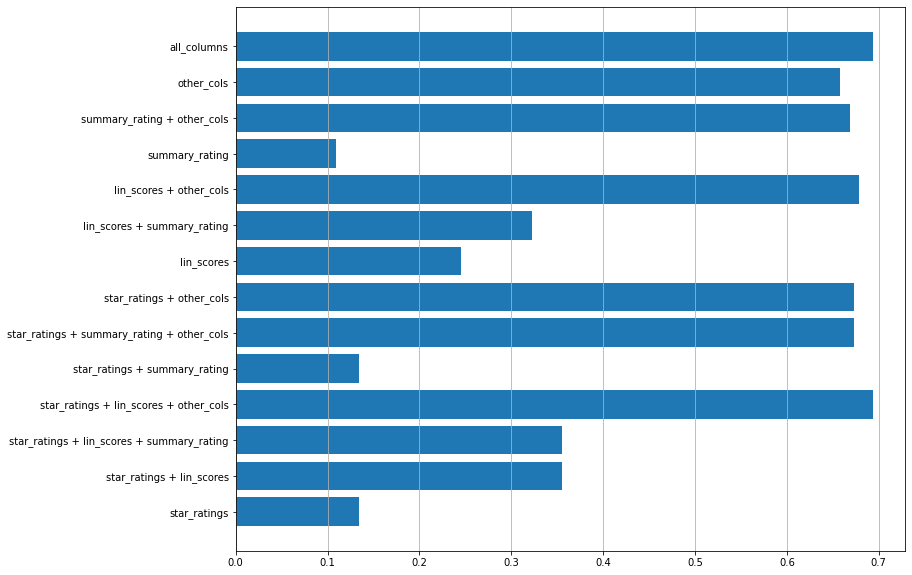

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,10))
plt.barh(list(x.keys()), list(x.values()))
plt.grid(axis="x")

#### With Classification


